# Optimization de paramètres ARIMA pour Chemours 2020

In [1]:
# %load ./_Snippets/finance_import_block.py
# Uncomment lorsque qu'une nouvelle ligne s'ajoute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings('ignore')

# Print automatiquement toutes les variables de la cellule (pas juste la dernière)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"last_expr" pour rétablir par défaut

%config InlineBackend.figure_format ='retina'

# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat

import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [2]:
ticker = 'CC'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2018-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
CC = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(CC.columns) 
col[-1] = 'Date'
CC.columns = col

# Set index to 'Date'
CC = CC.drop('date', axis=1).set_index('Date')
CC.index = pd.to_datetime(CC.index)


CC['rtn5'] = CC['close'].pct_change(5)*100
CC['rtn5_stdev'], CC_ravg = af.tfrm_to_MinusMean(CC['rtn5'])
col_drop = ['high', 'low', 'open', 'volume', 'adjclose']
CC.drop(columns= col_drop, inplace= True)

CC.dropna(inplace=True)
CC.head()

,close,rtn5,rtn5_stdev
Date,,,
2018-01-25,52.790001,2.306206,0.430501
2018-01-26,53.430000,-1.092188,-3.108807
2018-01-29,53.590000,-1.651682,-3.564700
2018-01-30,52.099998,-3.105825,-4.455186
2018-01-31,51.619999,-2.585399,-3.534233


In [3]:
CC_2019= CC.loc['06-2018':'12-2019']

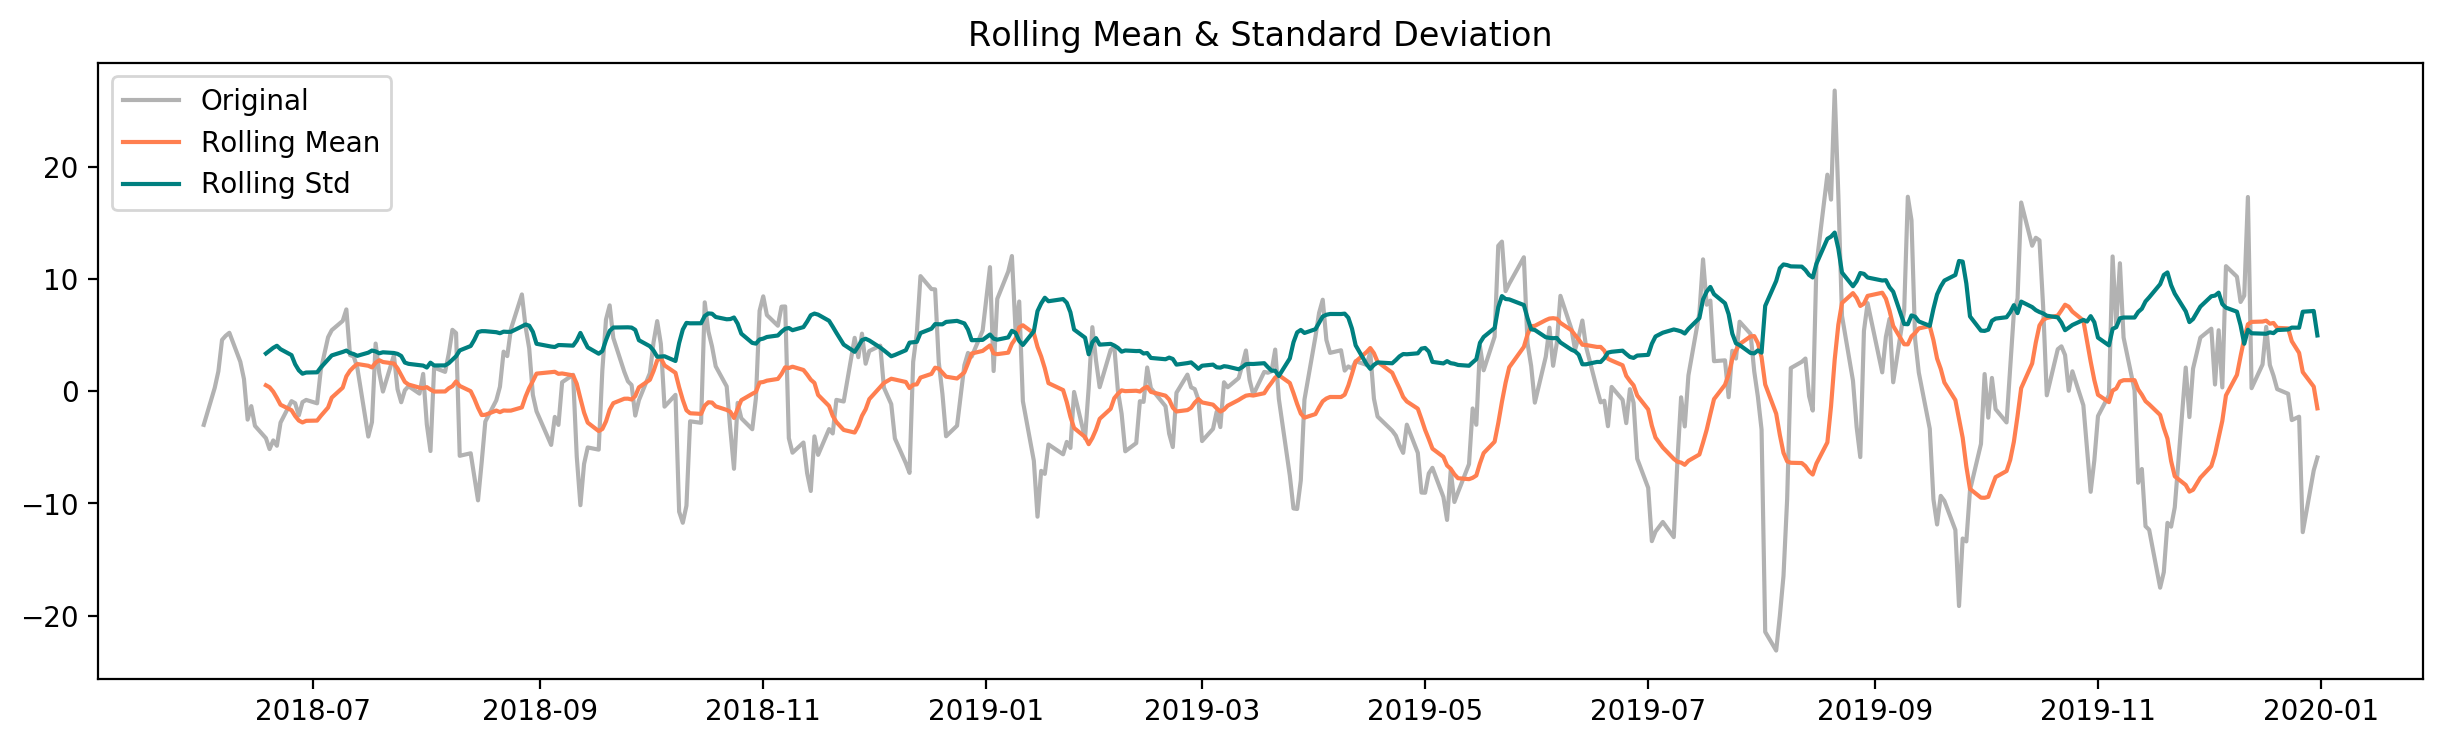

Mean MinMax Delta: 18.276219589423775
Std MinMax Delta: 12.780637727693074
ADF Statistic: -6.304240053645992
p-value: 3.353864239743117e-08
Critical Values:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181


In [20]:
# Assess transformed dataset performances
af.get_stationarity(CC_2019['rtn5_stdev'])

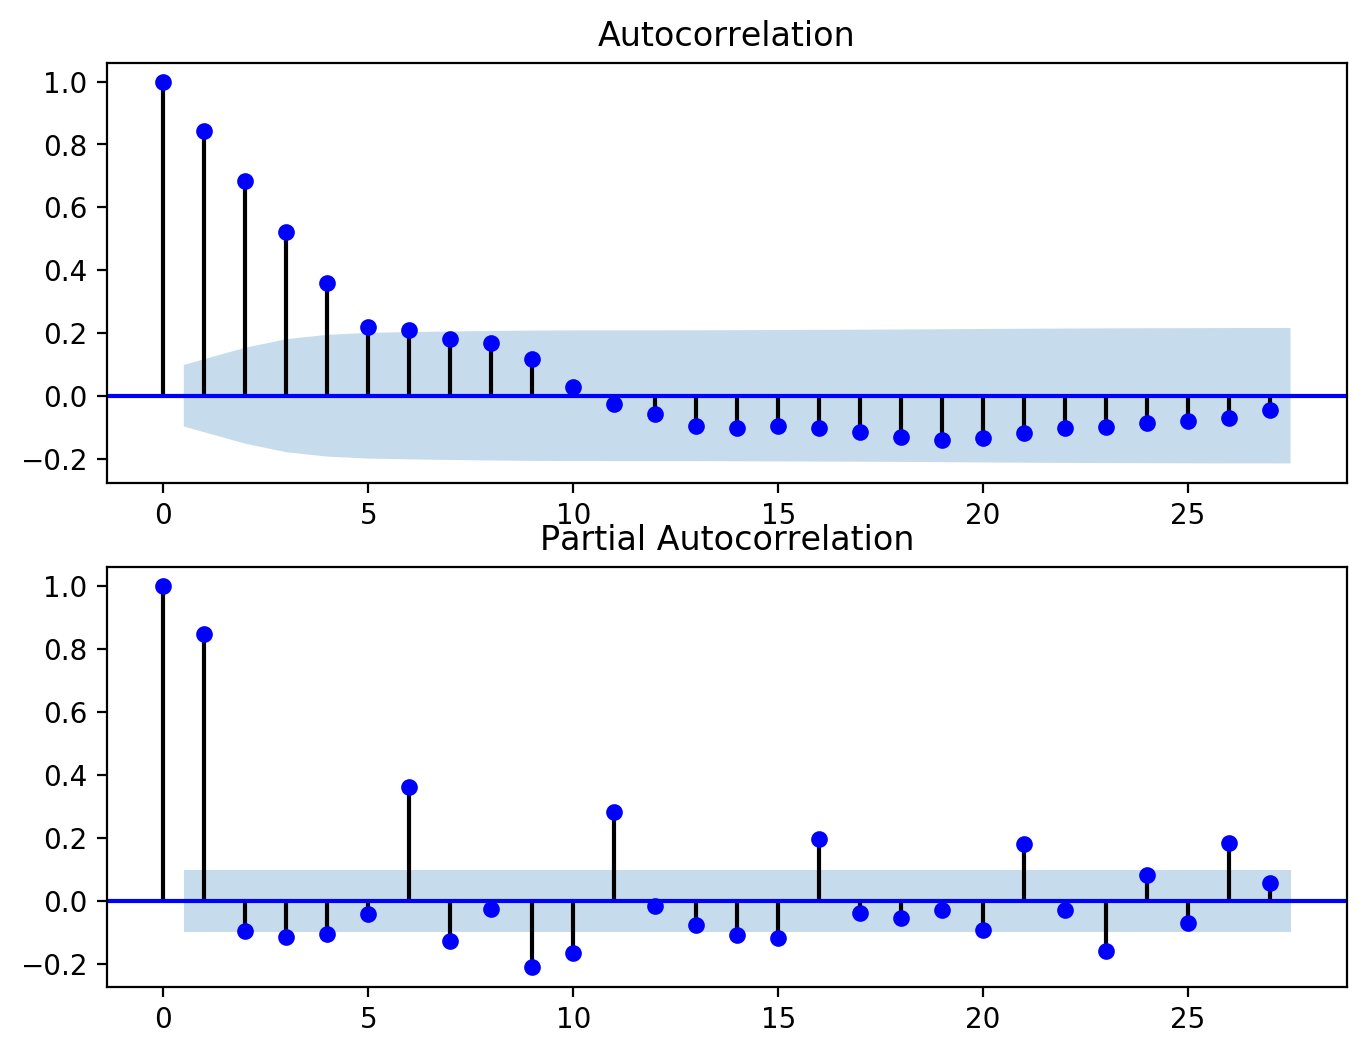

In [21]:
af.plot_corr_function(CC_2019['rtn5'])
plt.show()

In [23]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(CC_2019['rtn5_stdev'], ar_max_range= 16, ma_max_range= 8)

The AIC for an ARIMA(0, 0, 0) is:  2655 
The AIC for an ARIMA(0, 0, 1) is:  2411 
The AIC for an ARIMA(0, 0, 2) is:  2296 
The AIC for an ARIMA(0, 0, 3) is:  2276 
The AIC for an ARIMA(0, 0, 4) is:  2061 
The AIC for an ARIMA(0, 0, 5) is:  2063 
The AIC for an ARIMA(0, 0, 6) is:  2065 
The AIC for an ARIMA(0, 0, 7) is:  2067 
The AIC for an ARIMA(1, 0, 0) is:  2241 
The AIC for an ARIMA(1, 0, 1) is:  2238 
The AIC for an ARIMA(1, 0, 2) is:  2236 
The AIC for an ARIMA(1, 0, 3) is:  2194 
The AIC for an ARIMA(1, 0, 4) is:  2063 
The AIC for an ARIMA(1, 0, 5) is:  2049 
The AIC for an ARIMA(1, 0, 6) is:  2051 
The AIC for an ARIMA(1, 0, 7) is:  2050 
The AIC for an ARIMA(2, 0, 0) is:  2236 
The AIC for an ARIMA(2, 0, 1) is:  2205 
The AIC for an ARIMA(2, 0, 2) is:  2206 
The AIC for an ARIMA(2, 0, 3) is:  2160 
The AIC for an ARIMA(2, 0, 4) is:  2065 
The AIC for an ARIMA(2, 0, 5) is:  2052 
The AIC for an ARIMA(2, 0, 6) is:  2054 
The AIC for an ARIMA(2, 0, 7) is:  2051 
The AIC for an A

### Optimal: (12,0,7)
L'AIC optimal est à 2042.
Comme on le retrouve sur plusieurs ordre différence, on peut trancher pour des paramètres optimaux à (12,0,7). Pour donner une polynomiale juste assez flexible pour attraper les détails, mais pas trop, il faudrait considérer (4,0,5) pour un AIC de 2052.

## Validation de performance
### Paramètres de 2019 sur data 2020 en crise

In [37]:
ticker = 'TROX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
trox_2020 = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(trox_2020.columns) 
col[-1] = 'Date'
trox_2020.columns = col

# Set index to 'Date'
trox_2020 = trox_2020.drop('date', axis=1).set_index('Date')

trox_2020['rtn5'] = trox_2020['adjclose'].pct_change(5)*100
trox_2020['rtn5_stdev'], trox_2020_ravg = af.tfrm_to_MinusMean(trox_2020['rtn5'])
col_drop = list(trox_2020.columns[:4])
trox_2020.drop(columns= col_drop, inplace= True)

trox_2020.dropna(inplace=True)
trox_2020.head()

,volume,adjclose,rtn5,rtn5_stdev
Date,,,,
2020-01-27,1851900,9.284901,-11.737515,-9.213959
2020-01-28,1037100,9.265456,-6.200777,-3.198093
2020-01-29,787400,9.177953,-5.600007,-1.713216
2020-01-30,819400,9.041841,-9.268292,-3.586026
2020-01-31,1887200,8.225159,-14.717733,-6.621883


In [18]:
CC_2020= CC.loc['06-2019':'08-2020']

In [23]:
window_size = 115

# Get temporary df of rolling averages
df_roll_temp= af.rollwin_ARIMA(CC_2020['rtn5_stdev'], 
                               actual= 'rtn5_stdev', 
                               ARIMA_order= (12,0,7), 
                               window_size= window_size)

In [24]:
# Stiching all together
df_roll_temp['rtn5'] = CC_2020['rtn5'].iloc[window_size: :]
df_roll_temp.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp['Pred_rtn5'] = df_roll_temp['rtn5'] - df_roll_temp['Erreur']
CC_2020_pred = df_roll_temp.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
CC_2020_pred['Erreur_Dir'] = ((CC_2020_pred['rtn5'] < 0) 
                                      & (CC_2020_pred['Pred_rtn5'] > 0)) | ((CC_2020_pred['rtn5'] > 0) 
                                                                                    & (CC_2020_pred['Pred_rtn5'] < 0))

In [25]:
CC_2020_pred['Erreur_Dir'].value_counts(normalize=True)

False    0.862245
True     0.137755
Name: Erreur_Dir, dtype: float64

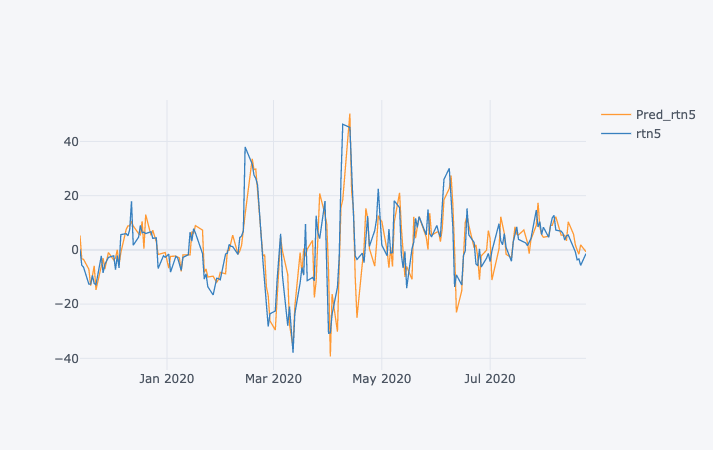

In [26]:
CC_2020_pred[['Pred_rtn5', 'rtn5']].iplot()

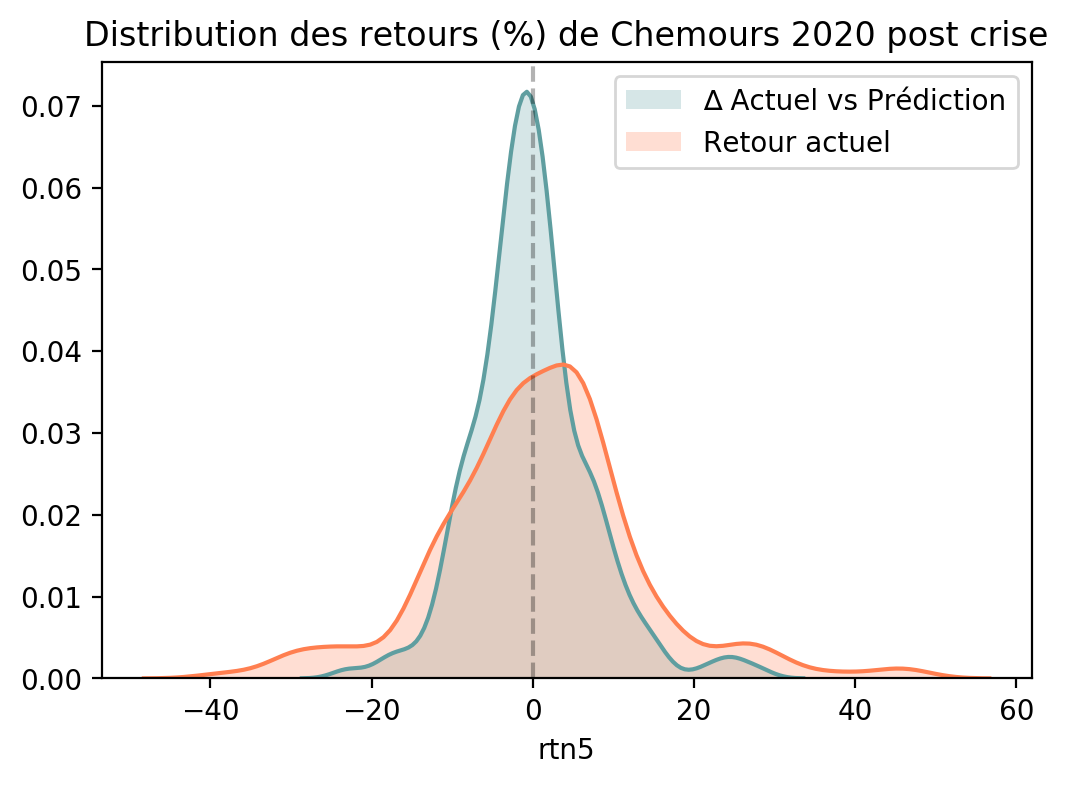

In [27]:
_= fig= plt.figure(figsize= (6, 4))
_= sns.distplot(CC_2020_pred['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(CC_2020_pred['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Chemours 2020 post crise')
plt.show()

In [28]:
print("Moyenne de l'erreur: {:.3f}% ".format(CC_2020_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(CC_2020_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(CC_2020_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(CC_2020_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(CC_2020_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(CC_2020_pred['Pred_rtn5'].std()))

Moyenne de l'erreur: -0.179% 
Écart type de l'erreur: 7.298%
____________________________
Retour moyen actuel: 0.936% 
Retour moyen prédit: 1.115% 
Écart type des retours actuels: 12.712%
Écart type des retours prédits: 12.066% 


### Conclusions
Chemours est clairement plus difficile à prédire que Tronox.
Malgré la crise l'erreur de direction est similaire aux autres titres comparables. Là où la crise semble avoir le plus grand influence, c'est sur la magnétude de la prédiction, légèrement moins précise que les comparables.